In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pyarrow.parquet as pq

# Load and preprocess the data
data = pq.read_table('cleaned_taxi_data.parquet')
data = data.to_pandas()
data['tips_percentage'] = (data['tip_amount'] / data['total_amount']) * 100


In [2]:
data.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge',
       ...
       'store_and_fwd_flag_1', 'payment_type_1', 'payment_type_2',
       'payment_type_3', 'payment_type_4', 'tip_bin_0', 'tip_bin_1',
       'tip_bin_2', 'tip_bin_3', 'tips_percentage'],
      dtype='object', length=177)

In [3]:
data.describe()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,...,store_and_fwd_flag_1,payment_type_1,payment_type_2,payment_type_3,payment_type_4,tip_bin_0,tip_bin_1,tip_bin_2,tip_bin_3,tips_percentage
count,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,...,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06,2.276461e+06
mean,1.472616e+00,2.017087e+00,9.898870e+00,1.023657e+00,4.994395e-01,1.966696e+00,4.196900e-03,2.999851e-01,1.543090e+01,2.434673e+00,...,7.788844e-03,7.807847e-01,2.155697e-01,2.394945e-03,1.250625e-03,3.378955e-01,5.871385e-01,7.437246e-02,5.934650e-04,1.204877e+01
std,1.039033e+00,1.671309e+00,5.098086e+00,1.194539e+00,1.673157e-02,1.719994e+00,1.745916e-01,2.113585e-03,6.083246e+00,3.988098e-01,...,8.791008e-02,4.137149e-01,4.112171e-01,4.887955e-02,3.534207e-02,4.729929e-01,4.923484e-01,2.623761e-01,2.435391e-02,7.865103e+00
min,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.020000e+00,6.500000e+00,0.000000e+00,5.000000e-01,8.000000e-01,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.795991e+00
50%,1.000000e+00,1.610000e+00,8.500000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.416000e+01,2.500000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.661017e+01
75%,2.000000e+00,2.520000e+00,1.200000e+01,2.500000e+00,5.000000e-01,2.860000e+00,0.000000e+00,3.000000e-01,1.790000e+01,2.500000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.666667e+01
max,7.000000e+00,9.990000e+01,3.000000e+02,4.550000e+01,5.000000e-01,3.500000e+02,2.620000e+01,3.000000e-01,3.573000e+02,2.750000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.940000e+01


In [4]:
X = data.drop(['tip_bin_0', 'tip_bin_1', 'tip_bin_2', 'tip_bin_3'], axis=1) # 0:"[0%, 10%]", 1:"(10%, 20%]", 2:"(20%, 50%]", 3:"(50%, 100%]
y = data[['tip_bin_0', 'tip_bin_1', 'tip_bin_2', 'tip_bin_3']]  # One-hot encoded labels

# Convert one-hot encoded labels to class indices for PyTorch CrossEntropyLoss
y_class_indices = np.argmax(y.values, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
X, y_class_indices, test_size=0.3, random_state=1, stratify=y_class_indices)

In [5]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the pandas dataframes to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.int64))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.int64))

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)




In [6]:
# Define the Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 4)  # Output layer for 4 classes
        
    def forward(self, x):
        return self.linear(x)  

# Initialize model with the number of input features
model = SoftmaxRegression(X_train.shape[1])

# Define the optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



Epoch 1, Loss: 0.1812, Train Acc: 97.50%, Test Acc: 97.50%
Epoch 2, Loss: 0.1091, Train Acc: 97.48%, Test Acc: 97.48%
Epoch 3, Loss: 0.0939, Train Acc: 97.55%, Test Acc: 97.55%
Epoch 4, Loss: 0.0858, Train Acc: 97.56%, Test Acc: 97.57%
Epoch 5, Loss: 0.0806, Train Acc: 97.65%, Test Acc: 97.65%
Epoch 6, Loss: 0.0768, Train Acc: 97.64%, Test Acc: 97.65%
Epoch 7, Loss: 0.0739, Train Acc: 97.68%, Test Acc: 97.69%
Epoch 8, Loss: 0.0716, Train Acc: 97.73%, Test Acc: 97.73%
Epoch 9, Loss: 0.0697, Train Acc: 97.72%, Test Acc: 97.74%
Epoch 10, Loss: 0.0682, Train Acc: 97.74%, Test Acc: 97.76%


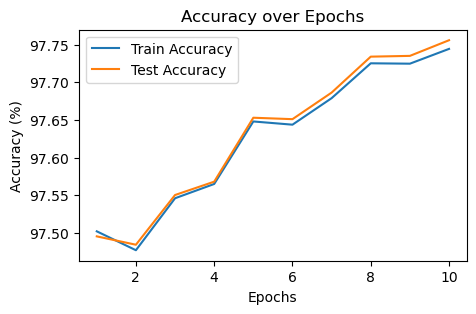

In [14]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 4)  # Output layer for 4 classes
        
    def forward(self, x):
        return self.linear(x)

# Assume X_train.shape[1] is known and correct
model = SoftmaxRegression(X_train.shape[1])

# Define optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

train_accuracies = []
test_accuracies = []

for epoch in range(10):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_accuracy = evaluate_model(model, train_loader)
    test_accuracy = evaluate_model(model, test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()



Confusion Matrix:
[[230731     31      0      0]
 [   504 400472      4      0]
 [     0  14543  36194     55]
 [     0      0    259    146]]


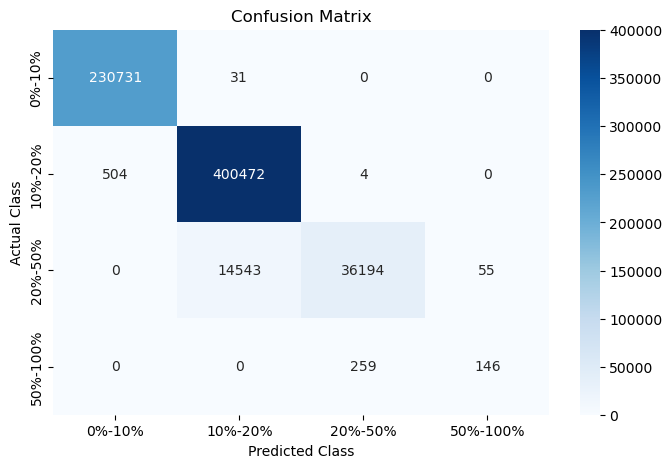

In [13]:
def get_predictions_and_targets(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())
    return all_targets, all_predictions

true_labels, predictions = get_predictions_and_targets(model, test_loader)


from sklearn.metrics import confusion_matrix

confusionmatrix = confusion_matrix(true_labels, predictions)
print(f"Confusion Matrix:\n{confusionmatrix}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0%-10%', '10%-20%', '20%-50%', '50%-100%'], yticklabels=['0%-10%', '10%-20%', '20%-50%', '50%-100%'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()




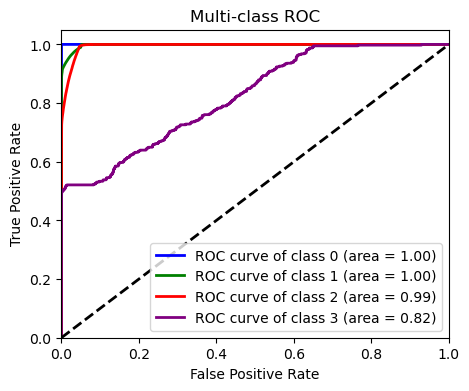

In [21]:
def get_scores_and_targets1(model, data_loader):
    model.eval()
    all_scores = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            softmax_scores = torch.softmax(outputs, dim=1)
            all_scores.extend(softmax_scores.tolist())
            all_targets.extend(targets.tolist())
    return all_targets, all_scores

true_labels, scores = get_scores_and_targets1(model, test_loader)



from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC
n_classes = len(np.unique(true_labels))  
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2, 3])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], np.array(scores)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(5, 4))
colors = ['blue', 'green', 'red', 'purple']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
